Build network for a single chromosome (c13):

In [181]:
## imports
import numpy as np
from bed_reader import open_bed
import os
from IPython.display import SVG
from sknetwork.embedding import LouvainNE
from sknetwork.visualization import svg_graph, svg_bigraph
from networkx.algorithms import bipartite
from scipy import sparse
from sknetwork.hierarchy import LouvainHierarchy
from sknetwork.hierarchy import cut_straight, dasgupta_score, tree_sampling_divergence
from sknetwork.visualization import svg_graph, svg_bigraph, svg_dendrogram
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import scipy.stats as stats
import pandas as pd
from scipy.stats import chi2_contingency

In [182]:
## get database workspace
file_name = '/Users/rishasurana/Library/CloudStorage/GoogleDrive-rsurana@usc.edu/.shortcut-targets-by-id/1I-Ssaub3M29w33JyrvO7HVv9laffGidc/chromosome_17_bed_bim_fam_data/ukb22418_c13_b0_v2.bed'


In [183]:
## read bed and select values
bed = open_bed(file_name)
print(bed.shape)

(488377, 26186)


In [187]:
values = bed.read(index=np.s_[0:25,0:25])
print(values.shape)
values = np.array(values)

(25, 25)


In [188]:
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  
  return stat/(obs*mini)

In [189]:
## build cramer's correlation matrix
import warnings ## temporarily hide NaN division warnings
warnings.filterwarnings("ignore")

rows= []

for var1 in values:
  col = []
  for var2 in values.T:
    cramers =cramers_V(var1, var2) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results)
df

ValueError: No data; `observed` has size 0.

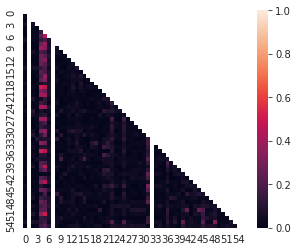

In [ ]:
## build correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
  ax = sns.heatmap(df, mask=mask,vmin=0., vmax=1, square=True)

plt.show()

Graph with 55 nodes and 53 edges


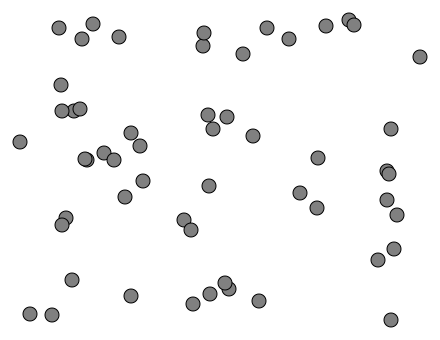

In [ ]:
## create adjacency matrix

## entire set
sA = sparse.csr_matrix(df)
G = nx.Graph(df)


## diagonal HL
sAArray = np.diagonal(df)
r,c = df.shape
M = np.zeros((r,c))
for x in range(0, r, 1):
    M[x,x] = sAArray.T[x]
    
M = sparse.csr_matrix(M)
G = nx.Graph(M)
print(G)


## continue
A = nx.adjacency_matrix(G)
sAA = sparse.csr_matrix(A)
## train classifier and build graph
louvain = LouvainNE(2)
embedding = louvain.fit_transform(sAA)
image = svg_graph(sAA, position=embedding)
SVG(image)